In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt
from datetime import timedelta
from datetime import datetime  
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [16]:
from sqlalchemy import MetaData
m = MetaData()
m.reflect(engine)
for table in m.tables.values():
    print("*******")
    print(table.name)
    for column in table.c:
        print(column.name,column.type)

*******
measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
*******
station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


2017-08-23 00:00:00
2016-08-22 12:00:00


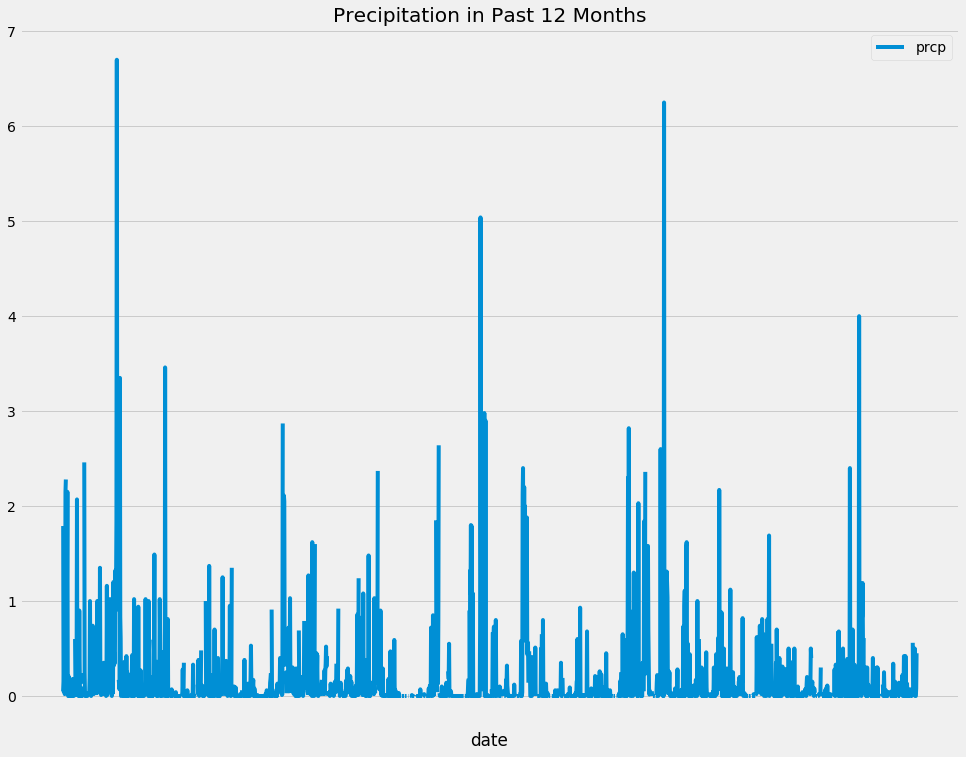

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement_df=pd.DataFrame(session.query(Measurement.id, Measurement.station,
                                          Measurement.date, Measurement.prcp, Measurement.tobs).all())


# Calculate the date 1 year ago from the last data point in the database
start_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
start_date_time = dt.datetime.strptime(start_date[0],'%Y-%m-%d')
print(start_date_time)
past_date_12mths = start_date_time + timedelta(days=-365.5)
print(past_date_12mths)
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_pyr=pd.DataFrame(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_date_12mths).all())
# Sort the dataframe by date
prec_pyr_df=prec_pyr.set_index('date').sort_values('date')
prec_pyr_df
# Use Pandas Plotting with Matplotlib to plot the data
prec_pyr_df.plot(title='Precipitation in Past 12 Months',figsize=[15,12],legend=True,xticks=[])

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_pyr_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
# Design a query to show how many stations are available in this dataset?
station_number = measurement_df.station.nunique()
print(f'{station_number} stations available')

9 stations available


In [47]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
measurement_df.station.value_counts().sort_values(ascending=False)
stations = dict(measurement_df.station.value_counts().sort_values(ascending=False))
next(iter(stations))

'USC00519281'

In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
print(session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all())


[(53.0, 87.0, 73.09795396419437)]


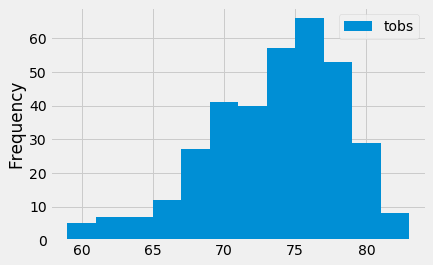

In [48]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_stn_df=pd.DataFrame(session.query(Measurement.station, Measurement.tobs).filter(Measurement.station==next(iter(stations))).filter(Measurement.date >= past_date_12mths).all())
most_active_stn_df.plot(kind='hist',bins=12)

![precipitation](Images/station-histogram.png)

In [49]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temp_tuple = calc_temps('2011-02-28', '2011-03-05')
tmin = temp_tuple[0][0]
tavg = temp_tuple[0][1]
tmax = temp_tuple[0][2]
tmin,tavg,tmax

(61.0, 69.75510204081633, 75.0)

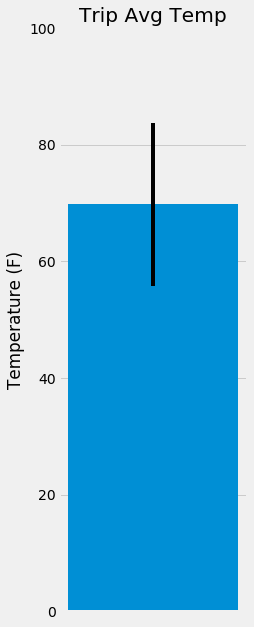

In [52]:
# Plot the results from your previous query as a bar chart.

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,10))

ax.bar(1,tavg,yerr=tmax-tmin)
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temperature (F)")
ax.grid(axis='x')
ax.set_ylim(top=100)
ax.get_xaxis().set_visible(False)

plt.show()

In [53]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.avg(Measurement.prcp)).\
            filter(Measurement.date >= '2011-02-28').filter(Measurement.date <= '2011-03-05').filter(Measurement.station == Station.station).\
            group_by(Station.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()
rainfall


[('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  0.5825),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.37166666666666665),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.365),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.392),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.24166666666666667),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.24),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.22999999999999998),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.126),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


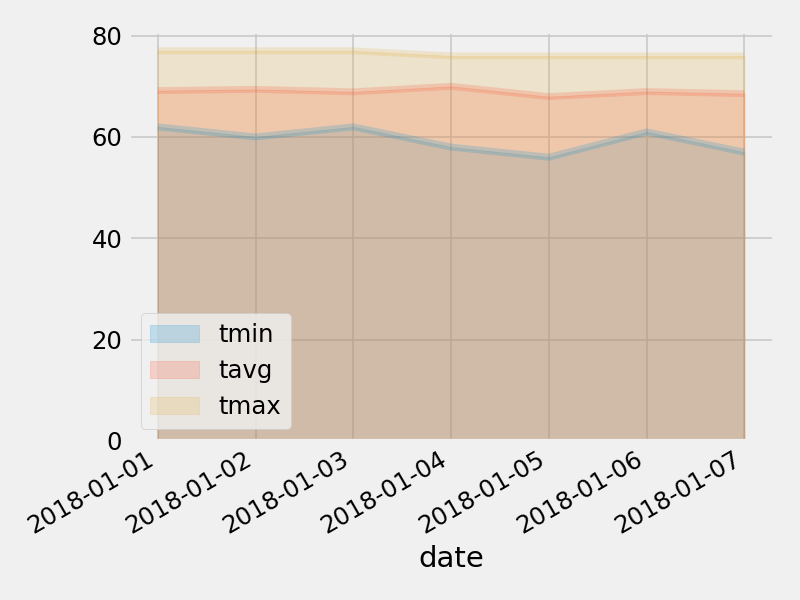

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
